# ColorNet

Markel Baskaran (markel.baskaran@alumni.mondragon.edu)

## 0. Introduction

The problem being addressed in this code is image colorization. Given a grayscale image as input, the objective is to predict the corresponding color image.

Image colorization is the process of adding colors to grayscale images. It is a complex task that requires understanding of the image content and careful adjustments to ensure high-quality results. Because objects can have multiple colors, there are many possible ways to assign colors to pixels in an image, making this task challenging.

Traditionally, image colorization is done manually in software like Photoshop, which can be time-consuming and require a lot of effort. To overcome these challenges, researchers have explored machine learning and deep learning techniques.

Deep learning, particularly convolutional neural networks (CNNs), has shown promise in solving image colorization problems. CNNs consist of multiple layers that process portions of the input image in a feed-forward fashion. Each layer applies different image filters, which extract different features of the input image, at different levels of abstraction.

Using CNNs for image colorization can significantly reduce the time and effort required for this task. It can also lead to more accurate and visually pleasing results. However, training CNNs for image colorization requires large datasets of colored and grayscale images, and careful tuning of various hyperparameters.

#### Color Representation

To render an image, we first represent it as a grid of pixels, where each pixel has a value that corresponds to its brightness. Grayscale images only have one layer, and the values range from 0–255, with 0 being black and 255 being white.

Color images, on the other hand, have three layers: Red, Green, and Blue (RGB). Each layer determines both color and brightness, and each pixel has a value from 0-255 in each layer. For example, a green leaf on a white background would have high values in the green layer and low values in the red and blue layers.

<img src="https://www.visidon.fi/wp-content/uploads/2021/03/koko-1024x1024.jpg"  width="600" height="600">

To use a neural network for image colorization, we need to find the features that link grayscale images with colored ones. The network learns the relationship between the input (grayscale values) and output (RGB values) by identifying these features. The goal is to train the network to predict the correct RGB values for each pixel in the input image, given its grayscale value. This requires a large dataset of colored and grayscale images and careful tuning of the network's architecture and parameters.

#### Problem definition

To predict the two color layers (a and b) given a grayscale image as input, we use a technique called colorization in Lab color space. Lab color space separates color information from brightness information. The L channel contains the brightness information (grayscale), while the a and b channels contain the color information.

To predict the a and b channels, we use convolutional filters, which are like the red and blue filters in 3D glasses. These filters highlight or remove specific features in the image to extract useful information. The network can use these filters to create new images from scratch or combine several filters into a single image.

Finally, we combine the L channel (grayscale image) with the predicted a and b channels to create the final colored image in Lab color space. To display this image on a computer or device, we need to convert it back to the RGB color space using a transformation matrix.

## 1. Preparing the data and preprocessing

First of all, we will import all the needed libraries.

In [2]:
# imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import pickle

from skimage.color import rgb2lab, lab2rgb

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

2023-03-15 20:39:59.137110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 20:39:59.821669: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/marbas/miniconda3/envs/tf/lib/
2023-03-15 20:39:59.821744: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/marbas/miniconda3/envs/tf/lib/
2023-03-15 20:39:59.821751: W tensorflow/compiler/tf2t

Define the paths to the training and testing datasets, the height and width of the images, and the batch size.

The selected dataset are images of different landscapes and colors.  In this case the size of the images has been set to 160x160. Basically because it is a multiple of 32 (multiples of 32 are convenient for the use of padding and striding techniques in the convolution layers, which helps to maintain the image size during processing) and because if we increase the resolution of the images the computation time of the training increases and with the limited capabilities we have these dimensions were chosen. 

In [3]:
TRAIN_PATH = 'datasets/images/color'
TEST_PATH = 'datasets/images/test'
VISUAL_TEST_PATH = 'datasets/images/test/test/visual'
REAL_TEST_PATH = 'datasets/images/real_test'

HEIGHT = 160
WIDTH = 160
BATCH_SIZE = 32 
INPUT_SHAPE = (HEIGHT, WIDTH, 1)

Correct, the next step in the image colorization process is to create image generators using the ImageDataGenerator class in Keras. This class provides a number of methods to read and preprocess images, such as rescaling, data augmentation, and data normalization.

In particular, we use the flow_from_directory method to read and preprocess the images. This method is useful when the images are sorted and placed in their respective class/label folders, as it automatically identifies the classes from the folder names.

When using flow_from_directory, we can specify various parameters such as batch size, image size, and class mode. We also use the rescale parameter to rescale/normalize the pixel values from the range of 0-255 to the range of 0-1, which is necessary for many machine learning models to work properly.

Once the image generators are created, we can use them to feed the data into our deep learning model for training and validation.

In [4]:
# Define the data generator with augmentation to generate augmented images for the training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        validation_split=0.05,
        horizontal_flip=True,
        featurewise_center=True)

# Generate flow of augmented images
# Train generator is a DirectoryIterator. It has items of (batch_size, height, width, channels) shape for each batch. 
train_generator = train_datagen.flow_from_directory(
        directory=TRAIN_PATH,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        subset='training',
        class_mode=None)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
        directory=TRAIN_PATH,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        subset='validation',
        class_mode=None)

Found 6108 images belonging to 1 classes.
Found 321 images belonging to 1 classes.


By adding data augmentation to our training process, we can reduce the risk of overfitting and improve the generalization performance of our deep learning model.

In Keras, we can use the ImageDataGenerator class to apply data augmentation by setting various parameters such as rotation_range, zoom_range, width_shift_range, height_shift_range, horizontal_flip, vertical_flip, brightness_range, etc. We can specify 4-6 random transformations as arguments to the ImageDataGenerator to apply during training.

The augmented data is generated on-the-fly during training, which means that the images are randomly transformed and generated during each training epoch. This can significantly increase the number of training examples and improve the model's ability to generalize to new data.

#### LAB tranformation

This section is critical because we are dealing with color images or RGB images, where each image and channel is significant, and it is necessary to predict values for each channel. To simplify the process, in this project, we convert RGB to LAB instead of predicting values for each channel individually.

LAB colorization is a colorization technique that converts RGB images into the LAB color space, which consists of three channels: Lightness (L), and the color channels a and b. The lightness channel L represents the brightness of the image, while the a and b channels represent the color information.

In the LAB color space, the a channel represents the color from green to red, while the b channel represents the color from blue to yellow. By separating the color information from the brightness information, the LAB color space makes it easier to manipulate color without affecting brightness, which makes it well-suited for image colorization tasks.

<img src="https://www.researchgate.net/publication/338303610/figure/fig1/AS:845707615428619@1578643816783/The-CIELAB-color-space-diagram-The-CIELAB-or-CIE-L-a-b-color-system-represents.jpg"  width="400" height="400">

In LAB colorization, a deep learning model is trained to predict the a and b channels of a grayscale image based on its corresponding lightness channel. Once the a and b channels are predicted, they are combined with the original lightness channel to obtain the final colorized image in the LAB color space. Finally, the colorized image is converted back to the RGB color space to display the result.

The advantage of using LAB colorization over other colorization techniques is that it produces more realistic and natural-looking colorized images with less color bleeding and artifacts. Additionally, it allows for more control over the colorization process, as it separates the color information from the brightness information.

This function generates batches of data to train a neural network that performs image colorization. 
It takes in a "train" object, which is an iterator that yields batches of RGB images. 
For each batch, it converts the RGB images to the Lab color space and separates the L channel (which contains brightness information) 
from the ab channels (which contain color information). 
It then scales the ab channels to be between -1 and 1, which is a common preprocessing step for neural networks. 
The function yields a tuple of two numpy arrays: the L channel and the scaled ab channels. 
These arrays are reshaped to include a channel dimension, which is necessary for convolutional neural networks. 
This function is designed to be used with the Keras fit_generator function.

In [5]:
def image_generator_rgb2lab(generator):
    for batch in generator:
        lab_batch = rgb2lab(batch)
        L_batch = lab_batch[:,:,:,0]
        ab_batch = lab_batch[:,:,:,1:]
        L_batch = L_batch
        ab_batch = ab_batch / 128.0 
        # returns (2, batch_size, height, width, channels)
        yield (L_batch.reshape(L_batch.shape+(1,)), ab_batch)

In this code, we start by creating an image_generator_rgb2lab object using the train_generator. This object generates batches of RGB images, which are then transformed to the LAB color space. We then create a batch of LAB images using the next() function. The L_batch and ab_batch arrays are separated from this batch, and the ab_batch values are multiplied by 128.

Next, we concatenate L_batch and ab_batch to get the original_batch, which we will use to show the different color channels. We then print the shapes of L_batch, ab_batch, a_batch, and b_batch.

After that, we separate the a and b channels from the ab_batch array and reshape them to add another dimension. Finally, we loop through the first four images in the original_batch and display the original image, the L channel, and the a and b channels in separate subplots. We use the lab2rgb function to convert the original_batch image back to the RGB color space before displaying it.

In [ ]:
# generate a batch of images
generator = image_generator_rgb2lab(train_generator)
# generator = image_generator_rgb2lab_(train_datagen)
lab_batch = next(generator)

# original_batch = np.concatenate(lab_batch, axis=-1)
L_batch = lab_batch[0]
ab_batch = lab_batch[1] * 128 # because of the normalization in the image_generator_rgb2lab
original_batch = np.concatenate((L_batch, ab_batch), axis=-1)


print("L batch shape: "+ str(L_batch.shape))
print("ab batch shape: "+ str(ab_batch.shape))

# Separate a and b channels
a_batch = ab_batch[:,:,:,0]
b_batch = ab_batch[:,:,:,1]
a_batch = a_batch.reshape(a_batch.shape+(1,))
b_batch = b_batch.reshape(b_batch.shape+(1,))

print("a batch shape: "+ str(a_batch.shape))
print("b batch shape: "+ str(b_batch.shape))

# Convert each image from RGB to Lab color space and separate channels
for i in range(4):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    original_batch[i] = lab2rgb(original_batch[i])
    axs[0].imshow(original_batch[i])
    axs[0].set_title('Original')
    axs[1].imshow(L_batch[i], cmap='gray')
    axs[1].set_title('L channel')
    axs[2].imshow(a_batch[i], cmap='RdYlGn_r')
    axs[2].set_title('a channel')
    axs[3].imshow(b_batch[i], cmap='YlGnBu_r')
    axs[3].set_title('b channel')
    plt.show()

In the code, we visualize four examples of transformed images, with their L, a, and b channels separated. The L channel shows the brightness information of the image, while the a and b channels represent the color information of the image.

The a channel represents the red-green color dimension, where positive values correspond to red colors and negative values correspond to green colors. The b channel represents the yellow-blue color dimension, where positive values correspond to yellow colors and negative values correspond to blue colors.

In the visualization, we can see that the L channel has the same brightness for all images, while the a and b channels vary depending on the color content of the original RGB image. The a channel is mainly highlighting the leaves of the trees, which are mostly green, and the b channel is mainly highlighting the blue sky. This illustrates how the a and b channels capture the color information of the image, while the L channel captures the brightness information.

**The goal with the L channel as input is to obtain the a and b channels.**

##  2. Define the model

This is a function that generates an autoencoder model for image processing. An autoencoder is a type of neural network that learns to compress and decompress data, in this case, images. The model is constructed using convolutional layers that perform operations like filtering, pooling, and concatenation.

The model consists of two parts, an encoder and a decoder. The encoder takes the input image and compresses it into a smaller representation, while the decoder takes this compressed representation and reconstructs the original image.

For example, the encoder layers use Conv2D and MaxPooling2D to reduce the size of the image and capture its features. The decoder layers use Conv2DTranspose and concatenation to upscale the compressed image back to its original size and reconstruct the color. The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution. 

Finally, the model output is a two-channel image with a tanh activation function. The generated model will be used for colorization but it can be used for denoising or image compression.

In [ ]:

def generate_autoencoder(input):
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoder
    # Con2DTranspose sometimes called Deconvolution
    up5 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    outputs = Conv2D(2, (1, 1), activation='tanh')(conv7)

    model = tf.keras.Model(inputs=input, outputs=outputs)

    return model


It is used the mean squared error (mse) loss function: we minimize the squared distance between the color value we try to predict, and the true (ground-truth) color value. This loss function is slightly problematic for colorization due to the multi-modality of the problem. For example, if a gray dress could be red or blue, and our model picks the wrong color, it will be harshly penalized. As a result, our model will usually choose desaturated colors that are less likely to be "very wrong" than bright, vibrant colors. 

In [ ]:
# compile the model
input = tf.keras.layers.Input(shape=(HEIGHT, WIDTH,1))
autoencoder = generate_autoencoder(input)
autoencoder.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])
autoencoder.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE 

generator_t = image_generator_rgb2lab(train_generator) # batch_size=32, X=L_batch, y=ab_batch
generator_v = image_generator_rgb2lab(validation_generator) # batch_size=32, X=L_batch, y=ab_batch

history = autoencoder.fit(x=generator_t,validation_data=generator_v, epochs=100, steps_per_epoch=steps_per_epoch, validation_steps = validation_steps, callbacks=[callback])

In [ ]:
#autoencoder.save("colornet.h5", history.history)

In [8]:
autoencoder = tf.keras.models.load_model('models/colornet.h5', )
with open("models/history.pkl", "rb") as f:
    history = pickle.load(f) 


2023-03-15 20:40:13.619211: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-03-15 20:40:13.619239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kafka
2023-03-15 20:40:13.619245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kafka
2023-03-15 20:40:13.619350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.5
2023-03-15 20:40:13.619369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.5
2023-03-15 20:40:13.619374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.85.5
2023-03-15 20:40:13.619682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (

Once the model is constructed, it can be fitted to the data. Due to the limited amount of data available, we may increase the number of epochs to allow for additional training. The performance of the model can be tracked over time by referring to a chart that displays the model's history.


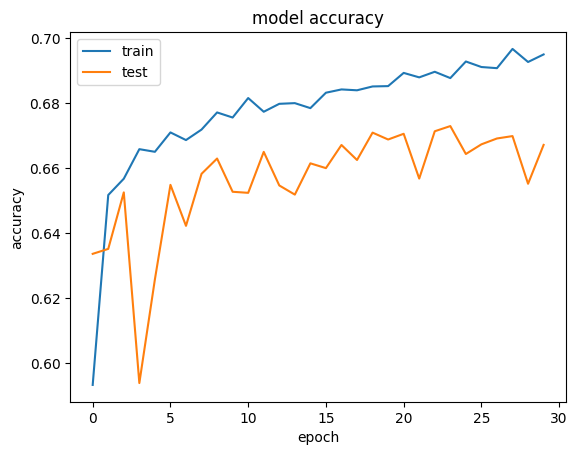

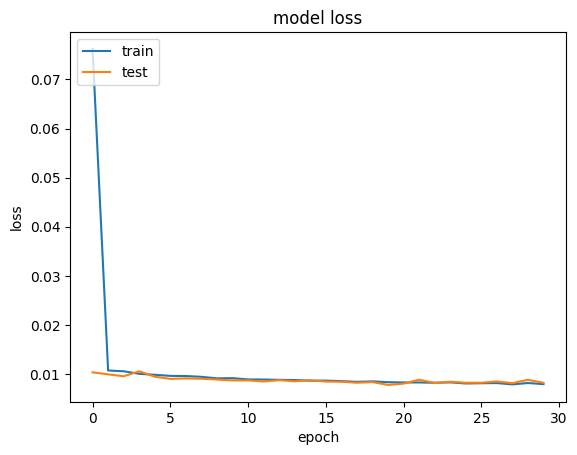

In [60]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3. Model Evaluation

Open the data test and preprocess the image. It almost the same treatment with the train dataset. We should resize the image size into 160x160 and normalize the image using ImageDataGenerator. We use the rescale argument to rescale / normalize the tensors from values between 0 and 255 to values between 0 and 1.

In [6]:
# Load and preprocessing the test images

image_size = (WIDTH, HEIGHT)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        )

test_generator = test_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=TEST_PATH,
                                                     target_size=image_size,
                                                     class_mode=None)

Found 711 images belonging to 1 classes.


Convert into LAB and evaluate the model. For the model evaluation MSE has been used and we get ~70% of accuracy.  

In [9]:
lab_batch = image_generator_rgb2lab(test_generator)
loss = autoencoder.evaluate(lab_batch, batch_size=BATCH_SIZE, steps=test_generator.samples)
print("Mean Squared Error (loss and accuracy): ", loss)

711/711 [==============================] - 1123s 2s/step - loss: 0.0081 - accuracy: 0.6880
Mean Squared Error (loss and accuracy):  [0.008143382146954536, 0.6879581212997437]


Here we choose the model will be evaluated visually. We choose 11 images randomly and we visualize all the channels that the model predicts. 

Found 11 images belonging to 1 classes.
1/1 [==============================] - 0s 324ms/step


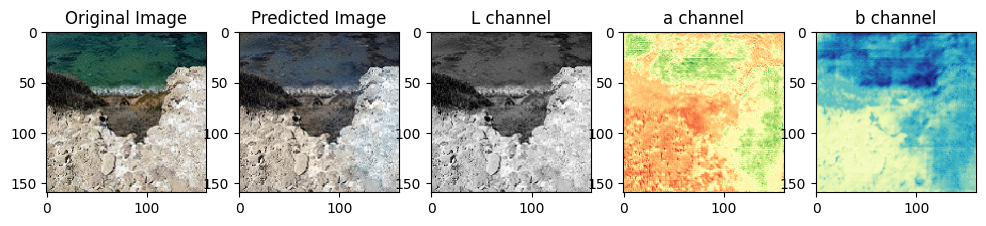

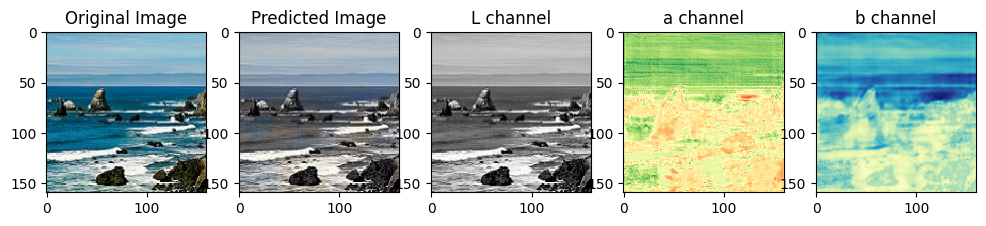

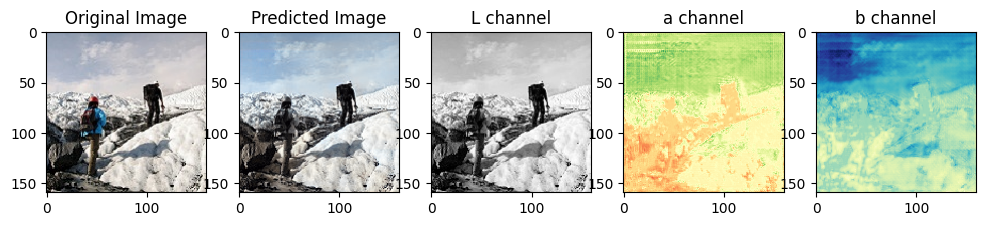

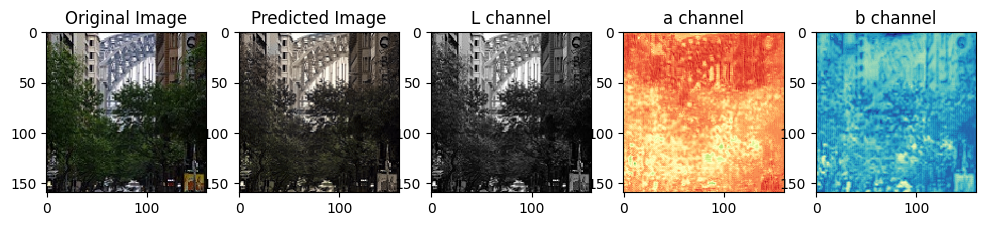

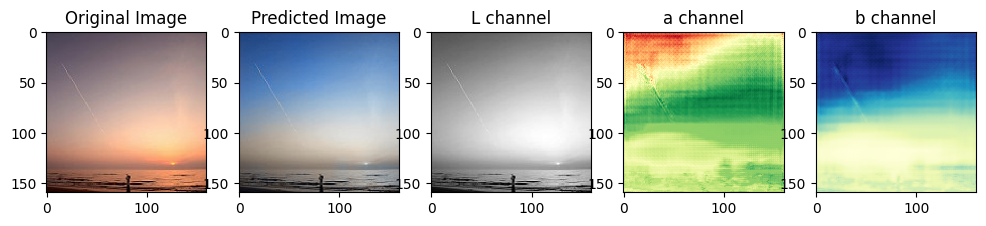

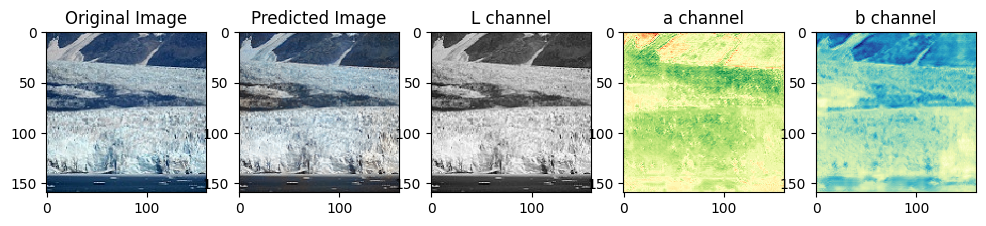

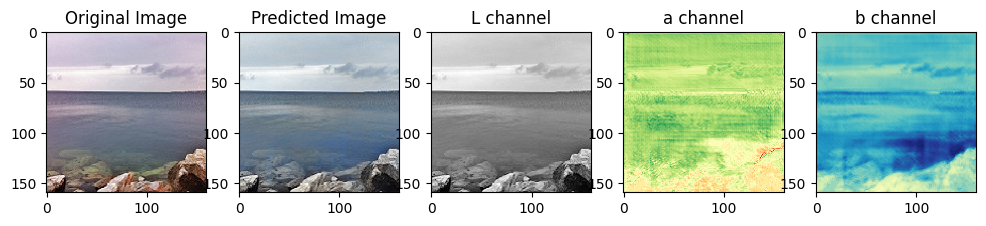

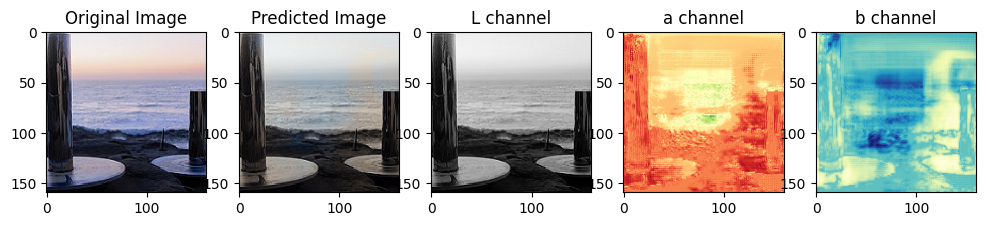

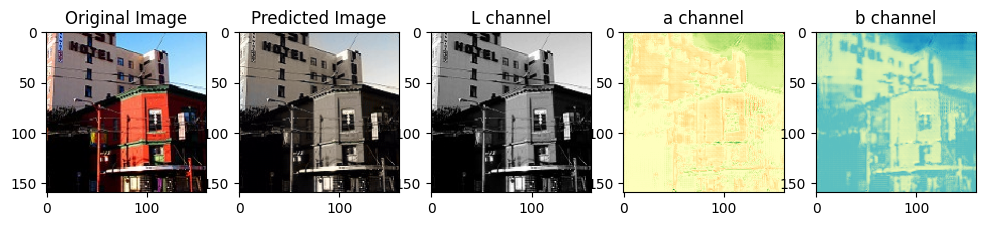

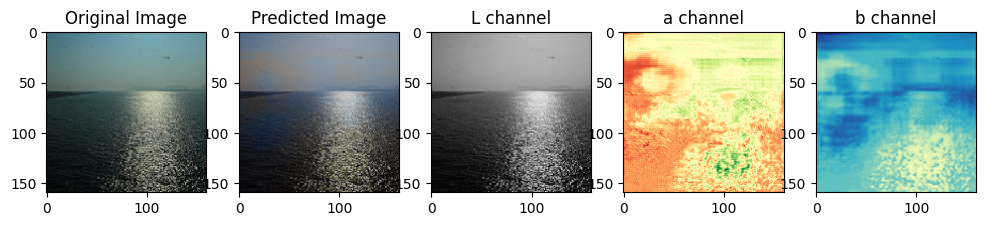

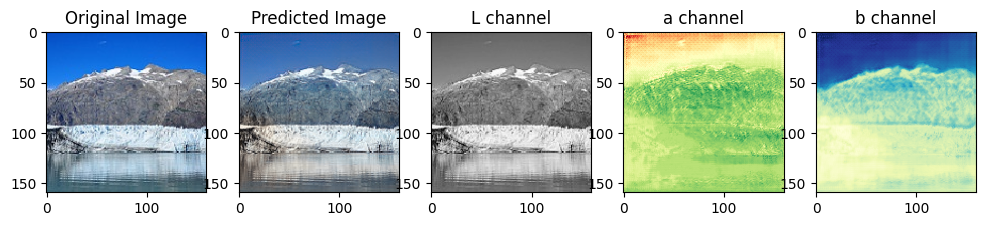

In [17]:
test_generator = test_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=VISUAL_TEST_PATH,
                                                     target_size=image_size,
                                                     class_mode=None)

#Convert to LAB
generator = image_generator_rgb2lab(test_generator)
lab_batch = next(generator)

L_batch = lab_batch[0]
ab_batch = lab_batch[1]

a_batch = ab_batch[:,:,:,0]
b_batch = ab_batch[:,:,:,1]
a_batch = a_batch.reshape(a_batch.shape+(1,))
b_batch = b_batch.reshape(b_batch.shape+(1,))

original_image = np.concatenate((L_batch, ab_batch*128), axis=-1)
original_image = lab2rgb(original_image)

predicted_batch = autoencoder.predict(L_batch)

a_batch = predicted_batch[:,:,:,0]
b_batch = predicted_batch[:,:,:,1]
a_batch = a_batch.reshape(a_batch.shape+(1,))
b_batch = b_batch.reshape(b_batch.shape+(1,))


for i in range(11):
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
  predicted_image = np.concatenate((L_batch[i], predicted_batch[i]*128), axis=-1) # axis=-1 in order to concatenate along the last axis
  predicted_image = lab2rgb(predicted_image)

  axs[0].imshow(original_image[i])
  axs[0].set_title('Original Image')
  axs[1].imshow(predicted_image)
  plt.imsave('elevator-pitch/predicted'+str(i)+'.jpeg',predicted_image)
  axs[1].set_title('Predicted Image')
  axs[2].imshow(L_batch[i], cmap='gray')
  axs[2].set_title('L channel')
  # plt.imsave('elevator-pitch/gray'+str(i)+'.jpeg',L_batch[i], cmap='gray')
  axs[3].imshow(a_batch[i], cmap='RdYlGn_r')
  axs[3].set_title('a channel')
  axs[4].imshow(b_batch[i], cmap='YlGnBu_r')
  axs[4].set_title('b channel')
  plt.show()

I choose some images online I have personally selected some images online to see the potential of the model. 

Found 7 images belonging to 1 classes.
1/1 [==============================] - 0s 211ms/step


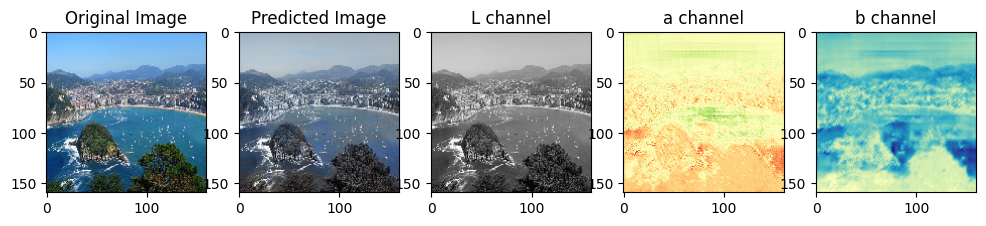

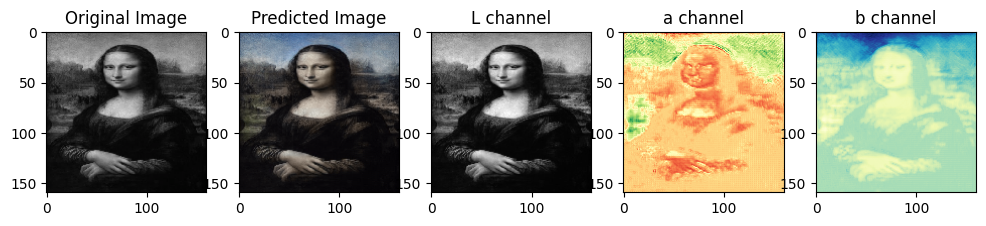

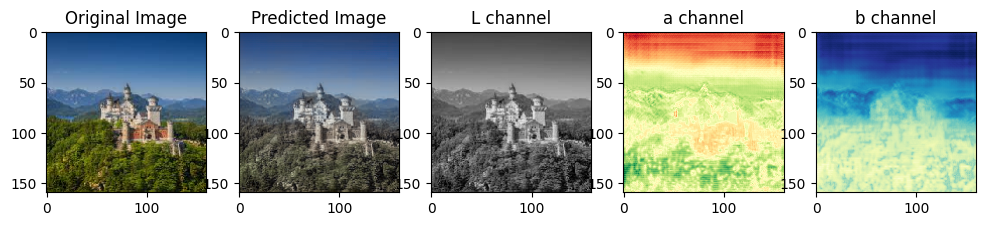

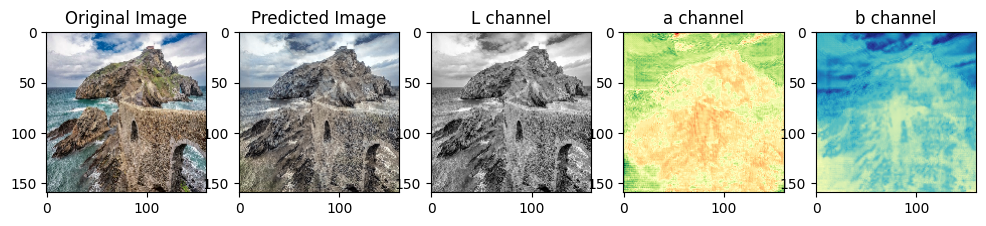

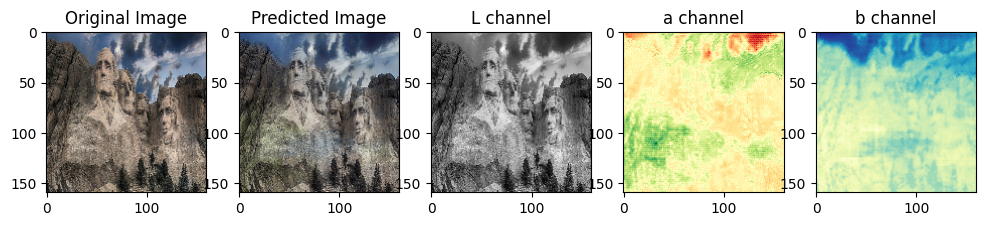

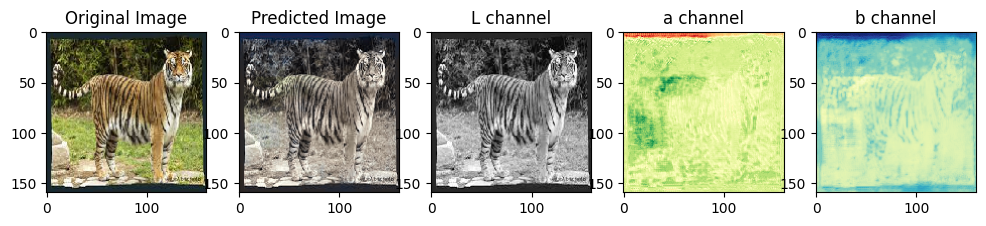

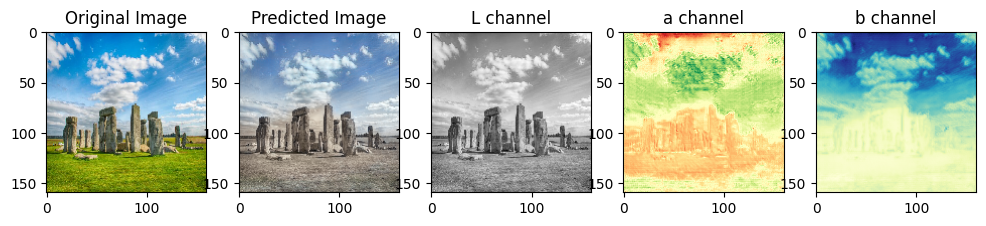

In [24]:
test_generator = test_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=REAL_TEST_PATH,
                                                     target_size=image_size,
                                                     class_mode=None)

#Convert to LAB
generator = image_generator_rgb2lab(test_generator)
lab_batch = next(generator)

L_batch = lab_batch[0]
ab_batch = lab_batch[1]

a_batch = ab_batch[:,:,:,0]
b_batch = ab_batch[:,:,:,1]
a_batch = a_batch.reshape(a_batch.shape+(1,))
b_batch = b_batch.reshape(b_batch.shape+(1,))

original_image = np.concatenate((L_batch, ab_batch*128), axis=-1)
original_image = lab2rgb(original_image)

predicted_batch = autoencoder.predict(L_batch)

a_batch = predicted_batch[:,:,:,0]
b_batch = predicted_batch[:,:,:,1]
a_batch = a_batch.reshape(a_batch.shape+(1,))
b_batch = b_batch.reshape(b_batch.shape+(1,))


for i in range(7):
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
  predicted_image = np.concatenate((L_batch[i], predicted_batch[i]*128), axis=-1) # axis=-1 in order to concatenate along the last axis
  predicted_image = lab2rgb(predicted_image)

  axs[0].imshow(original_image[i])
  axs[0].set_title('Original Image')
  axs[1].imshow(predicted_image)
  plt.imsave('elevator-pitch/predicted'+str(i)+'.jpeg',predicted_image)
  axs[1].set_title('Predicted Image')
  axs[2].imshow(L_batch[i], cmap='gray')
  axs[2].set_title('L channel')
  # plt.imsave('elevator-pitch/gray'+str(i)+'.jpeg',L_batch[i], cmap='gray')
  axs[3].imshow(a_batch[i], cmap='RdYlGn_r')
  axs[3].set_title('a channel')
  axs[4].imshow(b_batch[i], cmap='YlGnBu_r')
  axs[4].set_title('b channel')
  plt.show()

It can be seen that with landscape images it works quite well, as it is specially trained with landscapes. However, if we add an image that is not a landscape, it is hard enough for it to color well. As you can see in the image of the tiger. In fact, you can see that the image segmentation makes it quite decent since the u-net model is specialized in that. 

## 4. Conclusion

The present project provides evidence that an end-to-end deep learning architecture has the potential to be an effective solution for certain image colorization tasks. It is our contention that despite requiring some degree of human intervention, image colorization represents an area with significant potential for the future and could ultimately lead to a reduction in the number of hours required for supervised work.

This project is a basic approximation and the model can be greatly improved. First, with a larger computation and a larger database the model would learn more. On the other hand, the model could be improved by using a pre-trained model such as Inception Resnet V2 or VGG19. Also, in the last few years we have seen approaches with GANs that are predicted to be very close to reality. 